In [39]:
import numpy as np
import pandas as pd
import pickle

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', None)

In [40]:
pickle_in = open("processed_film_data","rb")
film_df = pickle.load(pickle_in)

In [41]:
film_df.head()

,actors,budget,countries,directors,genres,gross_usa,languages,mpaa,rating,runtime,votes,writers
0,"[Tom Selleck, Laura San Giacomo, Alan Rickman]",20000000,+_+Australia+_+USA,Simon Wincer,"[Action, Adventure, Drama, Romance, Western]",21413105,"[English, Aboriginal]",PG-13,6.8,119.0,16501,John Hill
1,"[Kevin Costner, Mary McDonnell, Graham Greene]",22000000,+_+USA+_+UK,Kevin Costner,"[Adventure, Drama, Western]",184208848,"[English, Sioux, Pawnee]",PG-13,8.0,181.0,204981,Michael Blake
2,"[Tony Todd, Patricia Tallman, Tom Towles]",4200000,+_+USA,Tom Savini,[Horror],5835247,[English],R,6.9,92.0,33738,John A. Russo
3,"[Jonathan Brandis, Kenny Morrison, Clarissa Burt]",36000000,+_+USA+_+Germany,George Miller,"[Adventure, Drama, Family, Fantasy]",17373527,[English],PG,5.1,90.0,20152,Karin Howard
4,"[David Andrews, Kelly Wolf, Stephen Macht]",10500000,+_+USA+_+Japan,Ralph S. Singleton,[Horror],11582891,[English],R,4.8,89.0,7824,Stephen King


In [42]:
#Delete all non-numeric rows
del film_df['actors']
del film_df['countries']
del film_df['languages']
del film_df['writers']
del film_df['directors']
del film_df['genres']
del film_df['mpaa']

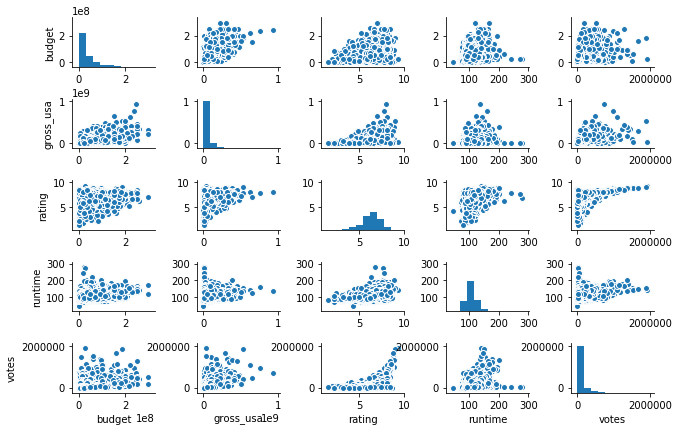

In [43]:
#Look at the pairplots.
sns.pairplot(film_df, size = 1.2, aspect=1.5);

In [44]:
#Apply log on these values, since I noticed a logarithmic relationship.
film_df['budget'] = film_df['budget'].apply(lambda x: np.log(x))
film_df['gross_usa'] = film_df['gross_usa'].apply(lambda x: np.log(x))
film_df['runtime'] = film_df['runtime'].apply(lambda x: np.log(x))
film_df['votes'] = film_df['votes'].apply(lambda x: np.log(x))

In [45]:
#Check the dataframe
film_df.head()

,budget,gross_usa,rating,runtime,votes
0,16.811243,16.879514,6.8,4.779123,9.711176
1,16.906553,19.031581,8.0,5.198497,12.230673
2,15.250595,15.579427,6.9,4.521789,10.426380
3,17.399029,16.670458,5.1,4.499810,9.911059
4,16.166886,16.265040,4.8,4.488636,8.964951


In [46]:
#Look at the correlation matrix
film_df.corr()

,budget,gross_usa,rating,runtime,votes
budget,1.000000,0.698278,0.101495,0.393750,0.645948
gross_usa,0.698278,1.000000,0.224856,0.298929,0.735892
rating,0.101495,0.224856,1.000000,0.429287,0.435957
runtime,0.393750,0.298929,0.429287,1.000000,0.366548
votes,0.645948,0.735892,0.435957,0.366548,1.000000


In [47]:
#Scale data
scaler = MinMaxScaler()

data = film_df.drop('rating', axis=1)
target = film_df['rating']

data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Diagnostics

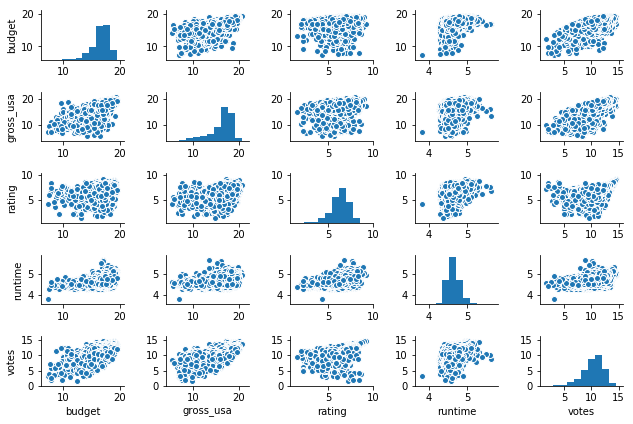

In [48]:
#Log-adjusted pairplots
sns.pairplot(film_df, size = 1.2, aspect=1.5);

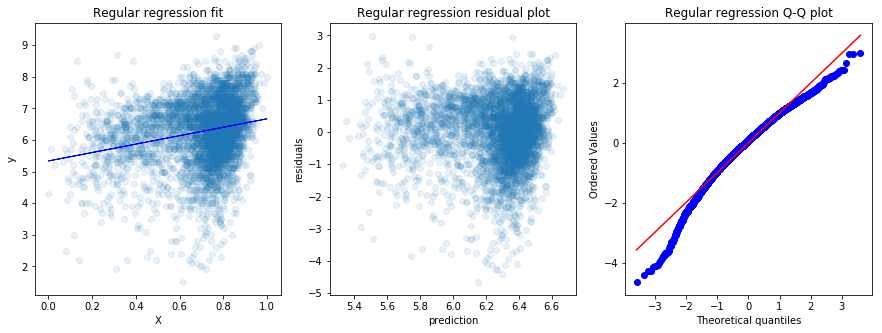

In [49]:
#Look at the diagnostic plots for one variable — gross_usa
plt.figure(figsize=(15,5))

X, y = data['gross_usa'].values.reshape(4455, 1), target

rgr = LinearRegression()
rgr.fit(X, y)
pred = rgr.predict(X)

plt.subplot(1, 3, 1)
plt.scatter(X, y, alpha = 0.1)
plt.plot(X, pred, color='blue', linewidth=1)
plt.title("Regular regression fit")
plt.xlabel("X")
plt.ylabel("y")

plt.subplot(1, 3, 2)
res = (y - pred)
plt.scatter(pred, res, alpha = 0.1)
plt.title("Regular regression residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

plt.subplot(1, 3, 3)
pred = rgr.predict(X)
stats.probplot(res, dist="norm", plot=plt)
plt.title("Regular regression Q-Q plot");

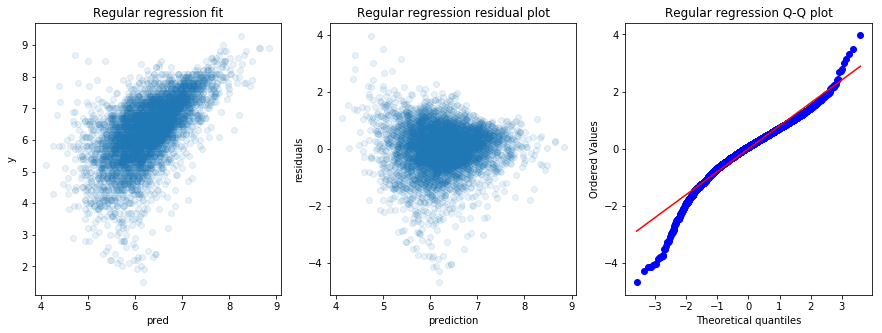

In [50]:
#Now look at the diagnostic plots for all variables
plt.figure(figsize=(15,5))

X, y = data, target

rgr = LinearRegression()
rgr.fit(X, y)
pred = rgr.predict(X)

plt.subplot(1, 3, 1)
plt.scatter(pred, y, alpha = 0.1)
plt.title("Regular regression fit")
plt.xlabel("pred")
plt.ylabel("y")

plt.subplot(1, 3, 2)
res = (y - pred)
plt.scatter(pred, res, alpha = 0.1)
plt.title("Regular regression residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

plt.subplot(1, 3, 3)
pred = rgr.predict(X)
stats.probplot(res, dist="norm", plot=plt)
plt.title("Regular regression Q-Q plot");

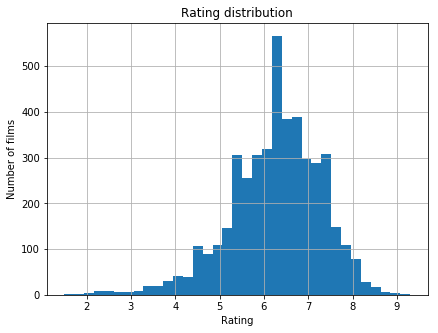

In [51]:
#And check the distribution of the target variable.
plt.figure(figsize=(15,5))
y = film_df['rating']
plt.subplot(1, 2, 1)
y.hist(bins = 35)
plt.title("Rating distribution")
plt.xlabel("Rating")
plt.ylabel("Number of films");

In [52]:
#Use statsmodels to look at the basic OLS model numbers.
model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 4.445e+04
Date:                Mon, 05 Feb 2018   Prob (F-statistic):               0.00
Time:                        11:40:07   Log-Likelihood:                -6286.2
No. Observations:                4455   AIC:                         1.258e+04
Df Residuals:                    4451   BIC:                         1.261e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
budget        -0.5843      0.153     -3.823      0.000      -0.884      -0.285
gross_usa     -0.6860      0.140     -4.896      0.000      -0.961      -0.411
runtime        7.9742      0.168     47.583      0.000       7.646       8.303
votes          5.0550      0.160     31.579      0.000       4.741       5.369
==============================================================================
Omnibus:                      183.712   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              578.880
Skew:                           0.060   Prob(JB):                    1.99e-126
Kurtosis:                       4.762   Cond. No.                         18.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Models

In [53]:
#This function will help me calculate the RMSE
def RMSE(actuals, preds): 
    return np.sqrt(np.mean((actuals - preds)**2))

In [54]:
#Divide the data into training, test, and validation sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)

## Model 1 - Basic Linear Regression

In [55]:
#Initialize the model
lr_model_1 = LinearRegression()
lr_model_1.fit(X_train, y_train);

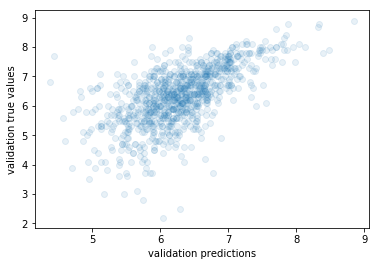

In [56]:
#Perform basic validation and look at the results.
plt.scatter(lr_model_1.predict(X_val), y_val, alpha=.1)
plt.plot(np.linspace(0,12,0.1),np.linspace(0,12,0.1))
plt.xlabel("validation predictions")
plt.ylabel("validation true values");

In [57]:
#Look at the model's RMSE and r^2
print("Basic Linear Regression RMSE: %.3f" %(RMSE(y_val, lr_model_1.predict(X_val))))
print("Basic Linear Regression r^2: %.3f" %(lr_model_1.score(X_val, y_val)))

Basic Linear Regression RMSE: 0.783
Basic Linear Regression r^2: 0.391


In [58]:
#Perform cross-validation
X_cv, y_cv = np.array(X), np.array(y)

cv_lm_r2s = []
cv_lm_rmse = []

for train_ind, val_ind in kf.split(X_cv, y_cv):
    
    X_cv_train, y_cv_train = X_cv[train_ind], y_cv[train_ind]
    X_val, y_val = X_cv[val_ind], y_cv[val_ind] 
    
    lr_model_1.fit(X_cv_train, y_cv_train)
    
    cv_lm_r2s.append(lr_model_1.score(X_val, y_val))
    cv_lm_rmse.append(RMSE(y_val, lr_model_1.predict(X_val)))

#Check RMSE and r^2 for cross-validation.
print('Basic Linear Regression mean cv r^2: %.3f +- %.3f' %(np.mean(cv_lm_r2s),np.std(cv_lm_r2s)))
print('Basic Linear Regression mean cv RMSE: %.3f +- %.3f' %(np.mean(cv_lm_rmse),np.std(cv_lm_rmse)))

Basic Linear Regression mean cv r^2: 0.369 +- 0.032
Basic Linear Regression mean cv RMSE: 0.802 +- 0.015


In [59]:
#Check r^2 on the test set.
lr_model_1.score(X_test, y_test)

0.35542344995410102

## Model 2 - LASSO regularization

In [60]:
#Define alphavec for LASSO and Ridge CV
alphavec = 10**np.linspace(-5,5,10)

In [61]:
#Scale the training set
std = StandardScaler()
std.fit(X_train);

In [62]:
#Transform the training data for LASSO regularization
X_lasso_train = std.transform(X_train)
X_lasso_val = std.transform(X_val)

In [63]:
#Initialize the model and perform cross-validation using in-built methods.
lr_model_2 = LassoCV(alphas = alphavec, cv=5)
lr_model_2.fit(X_lasso_train, y_train)

LassoCV(alphas=array([  1.00000e-05,   1.29155e-04,   1.66810e-03,   2.15443e-02,
         2.78256e-01,   3.59381e+00,   4.64159e+01,   5.99484e+02,
         7.74264e+03,   1.00000e+05]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [64]:
#Look at the coefficients.
list(zip(X_train.columns, lr_model_2.coef_))

[('budget', -0.40092943989991853),
 ('gross_usa', -0.04613288322502946),
 ('runtime', 0.39652375177779314),
 ('votes', 0.58490750183541818)]

In [65]:
#Look at a single validation set.
val_set_pred_2 = lr_model_2.predict(X_lasso_val)

In [66]:
#Check RMSE and r^2 for LASSO regularization for one validation set.
print('LASSO mean cv r^2: %.3f' %lr_model_2.score(X_lasso_val, y_val))
print('LASSO mean cv RMSE: %.3f' %np.sqrt(np.mean((val_set_pred_2 - y_val)**2)))

LASSO mean cv r^2: 0.375
LASSO mean cv RMSE: 0.804


In [67]:
#Check the model's r^2 on the test data.
lr_model_2.score(std.transform(X_test), y_test)

0.35587877385322675

## Model 3 - Ridge Regularization

In [68]:
#Scale the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [69]:
#Initialize the model and perform built-in cross-validation.
lr_model_3 = RidgeCV(alphas = alphavec, cv=5)
lr_model_3.fit(X_train_scaled,y_train)

RidgeCV(alphas=array([  1.00000e-05,   1.29155e-04,   1.66810e-03,   2.15443e-02,
         2.78256e-01,   3.59381e+00,   4.64159e+01,   5.99484e+02,
         7.74264e+03,   1.00000e+05]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [70]:
#Check the coefficients
list(zip(X_train.columns,lr_model_3.coef_))

[('budget', -0.39948712794160118),
 ('gross_usa', -0.045898962148000703),
 ('runtime', 0.39603141696808331),
 ('votes', 0.58333448503478291)]

In [71]:
#Look at one validation set...
val_set_pred_3 = lr_model_3.predict(X_val_scaled)

In [72]:
#... and check its RMSE and r^2
print('Ridge mean cv r^2: %.3f' %lr_model_3.score(X_val_scaled, y_val))
print('Ridge mean cv RMSE: %.3f' %np.sqrt(np.mean((val_set_pred_3 - y_val)**2)))

Ridge mean cv r^2: 0.375
Ridge mean cv RMSE: 0.804


In [73]:
#Test the model on the test set
lr_model_3.score(std.transform(X_test), y_test)

0.35584944519114392

## Model 4 - Linear Regression With Polynomials

In [74]:
#I will perform 5-fold cross-validation by using a loop, so I am going to create lists for r^2 and rmse, 
#and then calculate RMSE on the means of both lists.
cv_poly_r2s = []
cv_poly_rmse = []

for train_ind, val_ind in kf.split(X_cv,y_cv):
    
    X_train, y_train = X_cv[train_ind], y_cv[train_ind]
    X_val, y_val = X_cv[val_ind], y_cv[val_ind] 
    
    #polynomial degree 2
    poly = PolynomialFeatures(degree=2) 

    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    
    cv_poly_r2s.append(lm_poly.score(X_val_poly, y_val))
    cv_poly_rmse.append(RMSE(y_val, lm_poly.predict(X_val_poly)))

#Check r^2 and RMSE    
print('Polynomial mean on CV r^2: %.3f +- %.3f' %(np.mean(cv_poly_r2s),np.std(cv_poly_r2s)))
print('Polynomial mean on CV RMSE: %.3f +- %.3f' %(np.mean(cv_poly_rmse),np.std(cv_poly_rmse)))

Polynomial mean on CV r^2: 0.421 +- 0.030
Polynomial mean on CV RMSE: 0.768 +- 0.014


In [75]:
#Check r^2 on the test data.
lm_poly.score(poly.transform(X_test), y_test)

0.40066375540767585